# What is Upsell? : 

Upselling is a sales technique used by businesses to encourage customers to purchase a more expensive or upgraded version of a product or service, or to add additional items or features to their existing purchase. The goal of upselling is to increase the overall value of the customer's transaction, leading to higher revenue for the business.

## It seems that we have a large number of CSV files , let's load them up and discover each one

In [2]:
import warnings
import pandas as pd 
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import catboost
from catboost import CatBoostClassifier,  Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = "RdYlGn",
        square=True, 
        cbar_kws={'shrink':.5 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='black',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features for Training Dataset', y=1.05, size=15)
warnings.filterwarnings('ignore')


# I- Data exploration and cleaning :

In [3]:
csv1 = pd.read_csv(r'D:\Ooredoo internship\Upsell Project\upsell_2022\sample_upsell_data_15_eb.csv ')
csv2 = pd.read_csv(r'D:\Ooredoo internship\Upsell Project\upsell_2022\sample_upsell_data_15_eb_contacted_in.csv ')
csv3 = pd.read_csv(r'D:\Ooredoo internship\Upsell Project\upsell_2022\sample_upsell_data_15_eb_contacted_out.csv ')
csv4 = pd.read_csv(r'D:\Ooredoo internship\Upsell Project\upsell_2022\sample_upsell_data_15_eb_digital.csv ')
csv5 = pd.read_csv(r'D:\Ooredoo internship\Upsell Project\upsell_2022\sample_upsell_data_15_eb_rated.csv')
csv6 = pd.read_csv(r'D:\Ooredoo internship\Upsell Project\upsell_2022\sample_upsell_data_15_eb_recharge.csv')

In [4]:
print (csv1)

       subscriber_id  decision_utilisateur  interesse    revenu_upsell
0       2.149736e+09               Inconnu          0        Non achat
1       2.142784e+09  Client Non Interessé          0            Achat
2       2.149036e+09  Client Non Interessé          0  achat inf seuil
3       1.818780e+07               Inconnu          0        Non achat
4       2.154440e+09  Client Non Interessé          0            Achat
...              ...                   ...        ...              ...
12888   2.153620e+09      Client Interesse          1  achat inf seuil
12889   1.666460e+07      Client Interesse          1            Achat
12890   2.149356e+09      Client Interessé          1            Achat
12891   2.146000e+09               Inconnu          0        Non achat
12892   2.149304e+09      Client Interessé          1  achat inf seuil

[12893 rows x 4 columns]


the first csv file contains two important features one of which is our target feature. the first feature is 'decision_utilisateur' which contains different classifications of our customers. now the csv came with a premade numerical version of this feature but i'm going to drop it and remake a new one as i see fit.

the column contains some repetitions like client non interesse and client non interessé with é . so it will use some data cleaning :

We will be turning this into a numerical column so we should lump these users into bigger more general categories :

1) Interested : clients who are interested in the services of the company , this should include client interessé(and interesse) and vente programmé
2) non interested : clients who are not interested in the services which should include , non interesse and non interessé as well as refuse de collaborer, and frustrée
3) transformed : i'm not sure what this could imply as i don't have a data description but it may indicate that our customer came from a rival company or is thinking about going to a rival company, i think it's worth giving it its own category (will be revised upon seeing the data distribution and counts)
4) nan : these are the clients who's data we couldn't gather which should include  erreur audience ar,NAR,etc.. , appel interrompu 

In [5]:
# Extract the unique values from the 'decision_utilisateur' column
unique_values = csv1['decision_utilisateur'].unique()

# Count the occurrences of each unique value
value_counts = csv1['decision_utilisateur'].value_counts()

print (value_counts)

decision_utilisateur
Inconnu                        3659
Client Interesse               2900
Client Interessé               2289
Client Non Interesse           1113
Client Non Interessé            965
Transformé                      899
Erreur Audience AR              506
Vente programmee                205
Vente programmée                171
Client refuse de collaborer     151
Client frustre                   16
Client frustré                    6
Erreur audience NAR               5
Erreur Audience                   4
Appel Interrompu                  3
Transforme                        1
Name: count, dtype: int64


# Decision concerning first csv file : 

we will be creating two categories for the decision_utilisateur column and then creating dummy variables out of it : 

1) interested : this will include : Client Interesse,Client Interessé,Transformé,Vente programmee,Vente programmée
2) Non interested : this will include : Client Non Interesse,Client Non Interessé,Client refuse de collaborer, Client frustre,Client frustré

What about the error/nan values? : We will be looking at the initial distribution of the interested vs non interested and then deciding 

interested : 6 464
non interested : 2251
NAN : 4178

the missing values make up a large percentage of the dataset. We can't just randomly assign them, I believe it's best to add a new feature called unknown . perhaps this feature will capture the behavior of the customers during interviews / data collection and be meaningful. I don't feel confident dropping such a large number of rows nor assigning it arbitrary values. 

so our new plan for the decision_utilisateur column is : 3 categorical variables 

1) interested
2) non interested
3) unknown

In [6]:
#Replacing the values 
# First, replace the values for 'interested'
interested_values = ['Client Interesse', 'Client Interessé','Transforme', 'Transformé', 'Vente programmee' , 'Vente programmée']
csv1['decision_utilisateur'].replace(interested_values, 'interested', inplace=True)

# Then, replace the values for 'non interested'
non_interested_values = ['Client Non Interesse', 'Client Non Interessé', 'Client refuse de collaborer' , 'Client frustre', 'Client frustré']
csv1['decision_utilisateur'].replace(non_interested_values, 'non interested', inplace=True)

# Finally, replace the remaining values with 'unknown'
remaining_values = ['Inconnu', 'Erreur Audience AR' , 'Erreur audience NAR', 'Erreur Audience', 'Appel Interrompu' , 'Transforme']
csv1['decision_utilisateur'].replace(remaining_values, 'unknown', inplace=True)
# Drop the "interesse" column
csv1 = csv1.drop(columns=['interesse'],axis=1.)
# Get dummies for "decision_utilisateur"
csv1 = pd.get_dummies(csv1, columns=['decision_utilisateur'], prefix='decision')
# Delete the original "decision_utilisateur" column
# Create a mapping for "revenu_upsell" values
revenu_mapping = {
    'Non achat': 0,
    'achat inf seuil': 1,
    'Achat': 2
}

# Map the values in the "revenu_upsell" column
csv1['revenu_upsell'] = csv1['revenu_upsell'].map(revenu_mapping)

In [7]:
print (csv2)

       subscriber_id     mois  nb_contacted_in
0         2149187889  2022/08               45
1            4717541  2022/06               95
2           11898265  2022/07               45
3         2148928385  2022/08               54
4         2150651792  2022/07               93
...              ...      ...              ...
80078     2140434077  2022/09               26
80079     2162305206  2022/12               16
80080         127118  2022/12               52
80081       15888921  2022/10               44
80082     2151419807  2022/07              106

[80083 rows x 3 columns]


In [8]:
print (csv3)

       subscriber_id     mois  nb_contacted_in
0         2142797167  2022/08               15
1         2155279484  2022/06               21
2         2156339841  2022/11                7
3         2157316337  2022/12               35
4         2155412942  2022/06                9
...              ...      ...              ...
77430     2138911102  2022/10               10
77431     2153790973  2022/09               34
77432       12302129  2022/06               14
77433     2161446292  2022/09                6
77434     2153668731  2022/07               25

[77435 rows x 3 columns]


the second and third csvs seem to contain data about number of times our clients are being contacted and are contacting people. I will be merging these two csv files and creating an 'interaction' file which should help us figure out how much our customers are engaged with the company. Since we are not going to be forecasting and we are mostly interested in how much the features correlate with out target variable : revenu_upsell, we should be fine to group the merged dataset on the subscriber_id, averaging the number of interactions in and out.

In [9]:
interaction = pd.merge(csv2, csv3, on='subscriber_id', how='inner')


In [10]:
#Drop the 'mois_x' and 'mois_y' columns
interaction = interaction.drop(columns=['mois_x', 'mois_y'])

# Group by 'subscriber_id' and calculate the mean of 'nb_contacted_in_x' and 'nb_contacted_in_y'
grouped_interaction = interaction.groupby('subscriber_id').agg({'nb_contacted_in_x': 'mean', 'nb_contacted_in_y': 'mean'}).reset_index()

# Rename the columns if desired
grouped_interaction.columns = ['subscriber_id', 'average incoming interaction', 'average outgoing interaction']


In [11]:
# convert the float columns to integers
grouped_interaction['average incoming interaction'] = grouped_interaction['average incoming interaction'].astype(int)
grouped_interaction['average outgoing interaction'] = grouped_interaction['average outgoing interaction'].astype(int)


In [12]:
print (csv4)

      subscriber_id subscription_date_appli last_action_date_appli
0        2146437583     2023-01-14 17:11:16    2023-01-14 17:17:31
1           3967629     2020-06-10 00:31:09    2023-01-16 17:27:16
2        2154477972     2022-12-07 14:46:12    2022-12-07 14:50:40
3        2144501146     2020-04-29 15:09:40    2020-12-13 06:21:13
4           2360526     2022-03-31 17:13:17    2022-10-04 16:45:14
...             ...                     ...                    ...
6948     2140877312     2020-03-27 17:52:10    2023-02-17 10:26:46
6949       18545119     2021-09-05 08:47:20    2023-02-08 06:59:35
6950     2158581219     2021-08-26 00:46:54    2021-12-16 09:57:32
6951     2147387679     2022-02-23 15:47:44    2022-02-24 13:58:25
6952        1695791     2023-01-06 19:39:04    2023-02-21 12:47:38

[6953 rows x 3 columns]


# break from machine learning : RFM Analysis : 

Before continuing with the data cleaning and building a machine learning model I want to mention that we have enough data to create an RFM analysis. What is an RFM analysis? rfm is a way to segment data and come up with many insights including customer segmentation, customer retention rate, customer churn rate, cohort analysis, cross-selling, and up-selling. 

In order to work with RFM , three major data categories are needed : Recency, Frequency and Monetary: 

1) Recency : we can extract recency using the fourth csv 'sample_upsell_data_15_eb_digital' or the sixth one representing 'sample_upsell_data_15_eb_recharge' the first one seems to indicate the last and first time a customer interacted with the digital side of the services and the second one indicates the last and first time the customer interacted with putting money into their account.
2) Frequency : using the interaction dataset we created from merging the contacted csv files we have an idea about how frequently our user uses the services
3) Monetary : this is perhaps the hardest portion to calcualte but using the fifth csv  file 'sample_upsell_data_15_eb_rated' which contains information about how customers' usage of the ooredoo services we can create a new feature that counts how much money is spent per customer over their life in the company.

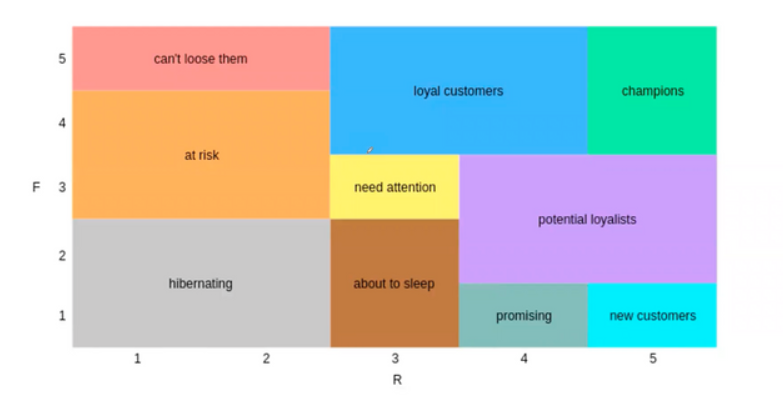

In [13]:
columns_to_include = ['subscriber_id', 'mou_out', 'volume_data', 'nb_sms_out']

# Create the 'monetary' DataFrame by selecting the specified columns
monetary = csv5[columns_to_include].copy()

In [14]:
rfm_monetary = monetary.groupby('subscriber_id').agg({'mou_out': 'sum', 'volume_data': 'sum', 'nb_sms_out': 'sum'}).reset_index()

now , using a simple formula and prices available online (price of one minute : 35 millimes , price of one megabyte : 5 millimes, price of one sms : 10 millimes   ) we can put a price on each customer symbolizing their consumption 


In [15]:
rfm_monetary['monetary'] = rfm_monetary['mou_out'] * 0.035 + (rfm_monetary['volume_data'] / 1024) * 0.005 + rfm_monetary['nb_sms_out'] * 0.010
rfm_monetary = rfm_monetary.drop(columns=['mou_out','volume_data','nb_sms_out'],axis=1.)


Now that the monetary dataset is ready , let's create the frequency and recency datasets :

In [16]:
columns_to_include = ['subscriber_id', 'average outgoing interaction']
frequency = grouped_interaction[columns_to_include].copy()

In [17]:
# Convert the 'last_action_date_appli' column to datetime
csv4['last_action_date_appli'] = pd.to_datetime(csv4['last_action_date_appli'])

# Calculate the difference in days between today's date and 'last_action_date_appli'
csv4['recency'] = (datetime.now() - csv4['last_action_date_appli']).dt.days

# Display the 'recency' DataFrame
recency = csv4[['subscriber_id', 'recency']]
print(recency)

      subscriber_id  recency
0        2146437583      226
1           3967629      224
2        2154477972      264
3        2144501146      989
4           2360526      328
...             ...      ...
6948     2140877312      193
6949       18545119      202
6950     2158581219      621
6951     2147387679      550
6952        1695791      188

[6953 rows x 2 columns]


### Now we have our three essential columns for the RFM analysis , let's create a new column containing an inner join of the three datasets : recency , frequency and rfm_monetary :

In [18]:
rfm = pd.merge(rfm_monetary, frequency, on='subscriber_id', how='inner')
rfm = pd.merge(rfm, recency, on='subscriber_id', how='inner')


In [19]:
rfm  = rfm .rename(columns={'average outgoing interaction': 'frequency'})
print (rfm)

      subscriber_id    monetary  frequency  recency
0              6600    3.150000          8      360
1             26303  139.834721         31      948
2             32689  186.451685        120      191
3             43628   81.923834         15      510
4             74676   42.054170         19      352
...             ...         ...        ...      ...
6558     2163235074    0.415788          7      433
6559     2163561082   17.425625         19      200
6560     2163561636   18.274027         19      193
6561     2163575426  277.437006         63      211
6562     2163924565    1.919445         12      371

[6563 rows x 4 columns]


In [20]:
rfm['monetary'] = rfm['monetary'].astype(float)
rfm['frequency'] = rfm['frequency'].astype(float)
rfm['recency'] = rfm['recency'].astype(float)
rfm['monetary'] = rfm['monetary'].astype(int)
rfm['frequency'] = rfm['frequency'].astype(int)
rfm['recency'] = rfm['recency'].astype(int)

In [21]:
rfm = rfm.set_index('subscriber_id')
rfm = rfm[rfm["monetary"] > 0]

In [22]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1])
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5])

In [23]:
rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                   rfm['frequency_score'].astype(str))

In [24]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Cant loose',
    r'3[1-2]': 'About to sleep',
    r'33': 'Need attention',
    r'[3-4][4-5]': 'Loyal customers',
    r'41': 'Promising',
    r'51': 'New customers',
    r'[4-5][2-3]': 'Potential loyalist',
    r'5[4-5]': 'Champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count"])


recency        frequency          monetary      
                          mean count       mean count        mean count
segment                                                                
About to sleep      365.412969   586  15.232082   586   23.976109   586
At Risk             898.230769  1027  35.757546  1027   86.649464  1027
Cant loose          925.502913   515  71.413592   515  151.151456   515
Champions           191.197880   566  56.395760   566  132.954064   566
Hibernating         839.585462  1018  16.086444  1018   29.902750  1018
Loyal customers     288.353306   968  58.200413   968  131.793388   968
Need attention      359.217742   248  29.733871   248   64.270161   248
New customers       191.026667   225  10.928889   225   17.635556   225
Potential loyalist  208.114087  1008  25.367063  1008   59.875992  1008
Promising           224.450820   244  10.696721   244   16.668033   244

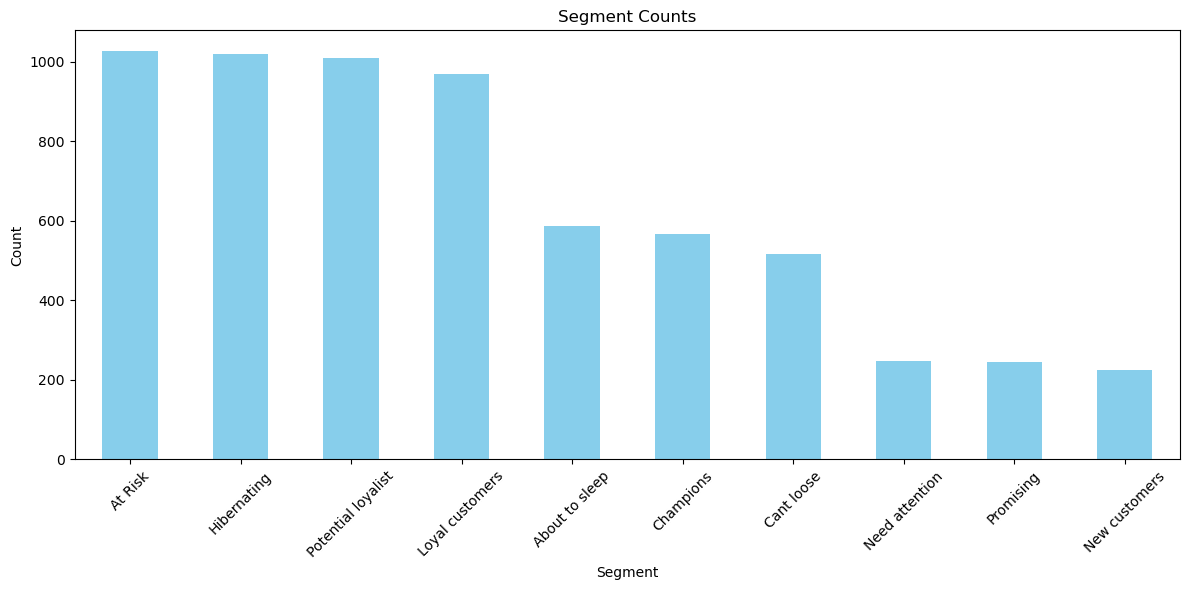

In [25]:
# Count the occurrences of each segment
segment_counts = rfm['segment'].value_counts()

# Create a bar chart
plt.figure(figsize=(12, 6))
segment_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.title('Segment Counts')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the chart
plt.show()

# RFM analysis takeaways : 

The RFM analysis has helped us segment our customers into different categories which will surely help the marketing time handle these customers and target them accordingly, which in turn will for sure help with increasing the upsell target feature. The bar chart of the different segments shows in order of importance  : 

#### 'At risk' : 
Low recency, high frequency, moderate monetary value. They used to be engaged but have become less active. Re-engage them with targeted offers.

#### 'Hibernating' :
Low recency, low frequency, low monetary value. These customers are inactive across the board. Consider reactivation campaigns or targeted incentives.

#### 'Potential loyalists' :
High recency, low frequency, high monetary value. They make significant purchases but not very often. Encourage them to buy more frequently.
We have a large number of potential loyalists definitely worth targeting.

#### 'Loyal Customers' :
High recency, high frequency, moderate monetary value. They are loyal but may not spend as much as champions. Encourage them to spend more through  upselling.

#### 'About to Sleep' : 
Low recency, moderate frequency, moderate monetary value. They might be slipping away. Target them with personalized offers to prevent them from becoming inactive.'

#### 'Champions' : 
High recency, high frequency, high monetary value. These are your most valuable and active customers. Nurture these relationships and offer exclusive rewards to maintain their loyalty.'

#### 'Cant Lose Them" :
Low recency, high frequency, high monetary value. While they may not be recent buyers, their high frequency and monetary value make them valuable. Keep them engaged with retention strategies.'


Now that we have finished a more marketing oriented analysis let's go back into the machine learning portion and finish cleaning/merging our data 

In [26]:
print (csv2)

       subscriber_id     mois  nb_contacted_in
0         2149187889  2022/08               45
1            4717541  2022/06               95
2           11898265  2022/07               45
3         2148928385  2022/08               54
4         2150651792  2022/07               93
...              ...      ...              ...
80078     2140434077  2022/09               26
80079     2162305206  2022/12               16
80080         127118  2022/12               52
80081       15888921  2022/10               44
80082     2151419807  2022/07              106

[80083 rows x 3 columns]


subscriber_id contains a lot of duplicates so we will group on it and drop the month column.

In [27]:
csv2 = csv2.drop(columns=['mois'], axis=1)

# Group by 'subscriber_id' and calculate the mean of 'nb_contacted_in_x' and 'nb_contacted_in_y'
grouped_csv2 = csv2.groupby('subscriber_id').agg({'nb_contacted_in': 'sum'}).reset_index()

# Rename the columns if desired
grouped_csv2.columns = ['subscriber_id', 'sum_nb_contacted_in']


In [28]:
print (grouped_csv2)

       subscriber_id  sum_nb_contacted_in
0               6600                  146
1              26303                  285
2              32526                  572
3              32689                 1091
4              34543                  131
...              ...                  ...
12032     2163942831                  199
12033     2164047805                  114
12034     2164054762                  428
12035     2164100837                  546
12036     2164108415                   35

[12037 rows x 2 columns]


In [29]:
print (csv3)

       subscriber_id     mois  nb_contacted_in
0         2142797167  2022/08               15
1         2155279484  2022/06               21
2         2156339841  2022/11                7
3         2157316337  2022/12               35
4         2155412942  2022/06                9
...              ...      ...              ...
77430     2138911102  2022/10               10
77431     2153790973  2022/09               34
77432       12302129  2022/06               14
77433     2161446292  2022/09                6
77434     2153668731  2022/07               25

[77435 rows x 3 columns]


same as csv2, but we will be renaming the column because this represents the outward going contacts not the inward ones 

In [30]:
csv3 = csv3.drop(columns=['mois'], axis=1)

# Group by 'subscriber_id' and calculate the mean of 'nb_contacted_in_x' and 'nb_contacted_in_y'
grouped_csv3 = csv3.groupby('subscriber_id').agg({'nb_contacted_in': 'sum'}).reset_index()

# Rename the columns if desired
grouped_csv3.columns = ['subscriber_id', 'sum_nb_contacted_out']


In [31]:
print (grouped_csv3)

       subscriber_id  sum_nb_contacted_out
0               6600                    57
1              26303                   220
2              32526                   320
3              32689                   843
4              34543                   102
...              ...                   ...
11856     2163942831                   127
11857     2164047805                    61
11858     2164054762                   323
11859     2164100837                   427
11860     2164108415                    24

[11861 rows x 2 columns]


In [32]:
print (csv4)

      subscriber_id subscription_date_appli last_action_date_appli  recency
0        2146437583     2023-01-14 17:11:16    2023-01-14 17:17:31      226
1           3967629     2020-06-10 00:31:09    2023-01-16 17:27:16      224
2        2154477972     2022-12-07 14:46:12    2022-12-07 14:50:40      264
3        2144501146     2020-04-29 15:09:40    2020-12-13 06:21:13      989
4           2360526     2022-03-31 17:13:17    2022-10-04 16:45:14      328
...             ...                     ...                    ...      ...
6948     2140877312     2020-03-27 17:52:10    2023-02-17 10:26:46      193
6949       18545119     2021-09-05 08:47:20    2023-02-08 06:59:35      202
6950     2158581219     2021-08-26 00:46:54    2021-12-16 09:57:32      621
6951     2147387679     2022-02-23 15:47:44    2022-02-24 13:58:25      550
6952        1695791     2023-01-06 19:39:04    2023-02-21 12:47:38      188

[6953 rows x 4 columns]


We'll use this column to create a 'duration' column representing how much time the client spent using non digital products, since this is the same as csv6 we will also use the same transformation to create a 'digital duration' column representing the number of days the customer sayed and drop the old columns 

In [33]:
print (csv6)

      subscriber_id subscription_date_appli last_action_date_appli
0        2146437583     2023-01-14 17:11:16    2023-01-14 17:17:31
1           3967629     2020-06-10 00:31:09    2023-01-16 17:27:16
2        2154477972     2022-12-07 14:46:12    2022-12-07 14:50:40
3        2144501146     2020-04-29 15:09:40    2020-12-13 06:21:13
4           2360526     2022-03-31 17:13:17    2022-10-04 16:45:14
...             ...                     ...                    ...
6948     2140877312     2020-03-27 17:52:10    2023-02-17 10:26:46
6949       18545119     2021-09-05 08:47:20    2023-02-08 06:59:35
6950     2158581219     2021-08-26 00:46:54    2021-12-16 09:57:32
6951     2147387679     2022-02-23 15:47:44    2022-02-24 13:58:25
6952        1695791     2023-01-06 19:39:04    2023-02-21 12:47:38

[6953 rows x 3 columns]


In [34]:
# Convert date columns to datetime objects
csv4['subscription_date_appli'] = pd.to_datetime(csv4['subscription_date_appli'])
csv4['last_action_date_appli'] = pd.to_datetime(csv4['last_action_date_appli'])

# Calculate the duration in days
csv4['duration'] = (csv4['last_action_date_appli'] - csv4['subscription_date_appli']).dt.days

# Convert the duration column to integers
csv4['duration'] = csv4['duration'].astype(int)

# Drop the original date columns
csv4 = csv4.drop(['subscription_date_appli', 'last_action_date_appli'], axis=1)


# Convert date columns to datetime objects
csv6['subscription_date_appli'] = pd.to_datetime(csv6['subscription_date_appli'])
csv6['last_action_date_appli'] = pd.to_datetime(csv6['last_action_date_appli'])

# Calculate the duration in days
csv6['duration'] = (csv6['last_action_date_appli'] - csv6['subscription_date_appli']).dt.days

# Convert the duration column to integers
csv6['duration'] = csv6['duration'].astype(int)

# Drop the original date columns
csv6 = csv6.drop(['subscription_date_appli', 'last_action_date_appli'], axis=1)


In [35]:
csv5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77357 entries, 0 to 77356
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   subscriber_id             77357 non-null  int64  
 1   mois                      77357 non-null  object 
 2   nb_days_used_voice        77357 non-null  int64  
 3   nb_days_used_sms          77357 non-null  int64  
 4   nb_days_used_data         77357 non-null  int64  
 5   mou_out                   77061 non-null  float64
 6   mou_out_onnet             77061 non-null  float64
 7   mou_out_offnet            77357 non-null  float64
 8   international_mou_out     77357 non-null  float64
 9   volume_data               77357 non-null  float64
 10  nb_sms_out                77357 non-null  int64  
 11  nb_sms_out_onnet          77357 non-null  int64  
 12  nb_sms_out_offnet         77357 non-null  int64  
 13  nb_sms_out_international  77357 non-null  int64  
dtypes: flo

In [36]:
csv5 = csv5.drop(columns=['mois'], axis=1)

# Group by 'subscriber_id' and calculate the mean of 'nb_contacted_in_x' and 'nb_contacted_in_y'
grouped_csv5 = csv5.groupby('subscriber_id').agg({'nb_days_used_voice': 'mean', 'nb_days_used_sms' :'mean','nb_days_used_data':'mean','mou_out':'sum','mou_out_onnet':'sum'
                                                 ,'mou_out_offnet':'sum','international_mou_out':'sum','volume_data':'mean','nb_sms_out':'sum'
                                                 ,'nb_sms_out_onnet':'sum','nb_sms_out_offnet':'sum','nb_sms_out_international':'sum'}).reset_index()


perfect, now let's merge our files into one big training set, since the objective of this notebook is to optimize the upsell i don't think we should be dropping any categories while we can. Our objective shouldn't be the accuarcy of the model but a model that is (obviously good at predicting) AND at capturing the relationship between our feature and the predicted feature, so we can use it to segment our customers and target them efficiently 

In [37]:
# Merge the CSVs based on the 'subscriber_id' column using pd.merge
inner_merge = pd.merge(csv1, csv2, on='subscriber_id', how='inner')
inner_merge = pd.merge(inner_merge, csv3, on='subscriber_id', how='inner')
inner_merge = pd.merge(inner_merge, csv4, on='subscriber_id', how='inner')
inner_merge = pd.merge(inner_merge, csv5, on='subscriber_id', how='inner')

outer_merge = pd.merge(csv1, csv2, on='subscriber_id', how='outer')
outer_merge = pd.merge(outer_merge, csv3, on='subscriber_id', how='outer')
outer_merge = pd.merge(outer_merge, csv4, on='subscriber_id', how='outer')
outer_merge = pd.merge(outer_merge, csv5, on='subscriber_id', how='outer')


In [38]:
print (inner_merge)

         subscriber_id  revenu_upsell  decision_interested  \
0         2.149736e+09              0                False   
1         2.149736e+09              0                False   
2         2.149736e+09              0                False   
3         2.149736e+09              0                False   
4         2.149736e+09              0                False   
...                ...            ...                  ...   
2076107   2.146000e+09              0                False   
2076108   2.146000e+09              0                False   
2076109   2.146000e+09              0                False   
2076110   2.146000e+09              0                False   
2076111   2.146000e+09              0                False   

         decision_non interested  decision_unknown  nb_contacted_in_x  \
0                          False              True                 56   
1                          False              True                 56   
2                          False    

In [39]:
inner_merge_no_duplicates = inner_merge.drop_duplicates(subset='subscriber_id')
print (inner_merge_no_duplicates)

         subscriber_id  revenu_upsell  decision_interested  \
0         2.149736e+09              0                False   
1372      2.142784e+09              2                False   
1715      1.818780e+07              0                False   
2058      2.154440e+09              2                False   
2401      2.507981e+06              1                False   
...                ...            ...                  ...   
2074615   2.136242e+09              0                 True   
2074740   2.160258e+09              0                False   
2075083   2.335478e+06              1                 True   
2075426   1.666460e+07              2                 True   
2075769   2.146000e+09              0                False   

         decision_non interested  decision_unknown  nb_contacted_in_x  \
0                          False              True                 56   
1372                        True             False                105   
1715                       False    

In [40]:
outer_merge_no_duplicates = outer_merge.drop_duplicates(subset='subscriber_id')
print (outer_merge_no_duplicates)

         subscriber_id  revenu_upsell  decision_interested  \
0         2.149736e+09              0                False   
1372      2.142784e+09              2                False   
1715      2.149036e+09              1                False   
1716      1.818780e+07              0                False   
2059      2.154440e+09              2                False   
...                ...            ...                  ...   
3787596   2.153620e+09              1                 True   
3787597   1.666460e+07              2                 True   
3787940   2.149356e+09              2                 True   
3788283   2.146000e+09              0                False   
3788626   2.149304e+09              1                 True   

         decision_non interested  decision_unknown  nb_contacted_in_x  \
0                          False              True               56.0   
1372                        True             False              105.0   
1715                        True    

In [41]:
print (outer_merge_no_duplicates.isnull().sum())

subscriber_id                  1
revenu_upsell                  0
decision_interested            0
decision_non interested        0
decision_unknown               0
nb_contacted_in_x            586
nb_contacted_in_y            762
recency                     5806
duration                    5806
nb_days_used_voice           766
nb_days_used_sms             766
nb_days_used_data            766
mou_out                      828
mou_out_onnet                828
mou_out_offnet               766
international_mou_out        766
volume_data                  766
nb_sms_out                   766
nb_sms_out_onnet             766
nb_sms_out_offnet            766
nb_sms_out_international     766
dtype: int64


In [42]:
print (inner_merge_no_duplicates.isnull().sum())

subscriber_id                0
revenu_upsell                0
decision_interested          0
decision_non interested      0
decision_unknown             0
nb_contacted_in_x            0
nb_contacted_in_y            0
recency                      0
duration                     0
nb_days_used_voice           0
nb_days_used_sms             0
nb_days_used_data            0
mou_out                     30
mou_out_onnet               30
mou_out_offnet               0
international_mou_out        0
volume_data                  0
nb_sms_out                   0
nb_sms_out_onnet             0
nb_sms_out_offnet            0
nb_sms_out_international     0
dtype: int64


In [43]:
# progress for hamdi later or tomorrow : welp now u have two datasets with relatively okay sizes one has an inner merge the other an outer merge
#u will clean the outer merge one from null values then you will train an xgboost/decision tree/random forest model on each of the datasets
# compare accuarcies then derive feature importance and then make conclusions if not lazy create market segments based on the most important
# features gl o7

### Training sets creation and handling newly created nan values :

I have decided to merge the datasets in two ways : 
1) first method is an outer join which will try to include as much information as it can in the final dataset , however this creates a problem of nan valus where the datasets don't have all the information concerning a client so this should be handled
2) second method is an inner join that will generate a smaller dataset that has the common subscriber_ids among all the datasets.


# OUTER MERGE :

In [44]:
#Cleaning the  merges :
outer_df = outer_merge_no_duplicates.drop(columns=['subscriber_id'], axis=1)
inner_df = inner_merge_no_duplicates.drop(columns=['subscriber_id'],axis=1)

Let's observe the nb_contacted in and out and see how to handle their nan values :

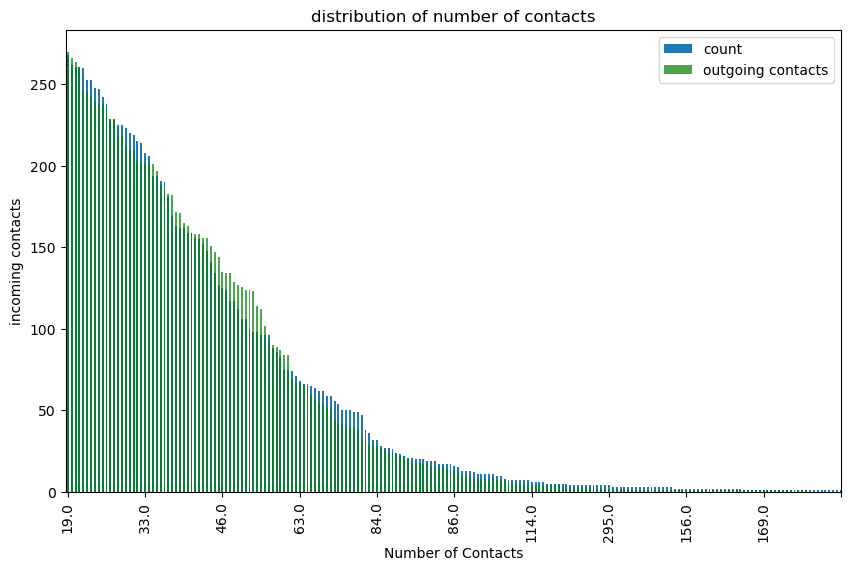

In [45]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Use the 'nb_contacted_in_x' column to create a count plot
outer_df['nb_contacted_in_x'].value_counts().plot(kind='bar')
outer_df['nb_contacted_in_y'].value_counts().plot(kind='bar', color='green', alpha=0.7, label='outgoing contacts')

# Add labels and a title
plt.xlabel('Number of Contacts')
plt.ylabel('incoming contacts')
plt.title('distribution of number of contacts')

# Add a legend to differentiate between the two columns
plt.legend()

# Customize the x-axis ticks with specific intervals (e.g., every 0.5)
x_ticks = [round(x, 1) for x in range(0, 201, 20)]
plt.xticks(x_ticks)
# Show the plot
plt.show()

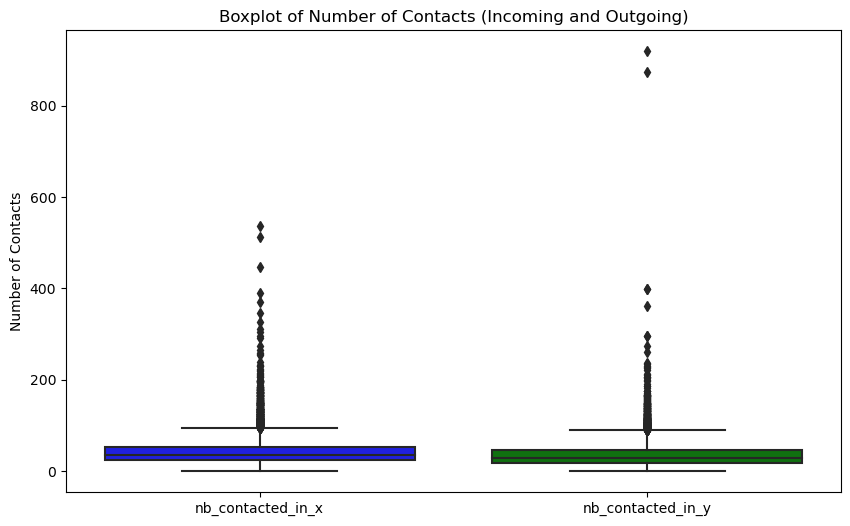

In [46]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Create a boxplot for 'nb_contacted_in_x' and 'nb_contacted_in_y' using Seaborn
sns.boxplot(data=outer_df[['nb_contacted_in_x', 'nb_contacted_in_y']], palette=['blue', 'green'])

# Add labels and a title
plt.ylabel('Number of Contacts')
plt.title('Boxplot of Number of Contacts (Incoming and Outgoing)')

# Show the plot
plt.show()


Not only is our data plagued with nan values , it also has a large number of outliers. we will be filling NA values with 0s since these have been created as a result of the merge which means we actually don't have the information and the nan values are not a result of some mistakes in the sampling.

We will be making a log transormation to reduce the dominance of nan values as well as fill the NAN values with 0s

In [47]:
outer_df.describe()

,revenu_upsell,nb_contacted_in_x,nb_contacted_in_y,recency,duration,nb_days_used_voice,nb_days_used_sms,nb_days_used_data,mou_out,mou_out_onnet,mou_out_offnet,international_mou_out,volume_data,nb_sms_out,nb_sms_out_onnet,nb_sms_out_offnet,nb_sms_out_international
count,12623.000000,12037.000000,11861.000000,6817.000000,6817.000000,11857.000000,11857.000000,11857.000000,11795.000000,11795.000000,11857.000000,11857.0,11857.000000,11857.000000,11857.000000,11857.000000,11857.0
mean,0.889012,41.263022,34.615715,516.673903,468.447264,21.835793,13.395884,19.978241,327.341191,180.485395,139.012679,0.0,4519.317194,42.142869,13.318293,9.251666,0.0
std,0.743722,29.532709,28.788217,361.584340,443.713597,9.171064,8.567898,10.684037,374.433968,261.139577,196.700645,0.0,7681.883744,115.652381,85.339050,63.667434,0.0
min,0.000000,1.000000,0.000000,188.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,24.000000,17.000000,209.000000,46.000000,16.000000,6.000000,11.000000,75.000000,28.716667,20.000000,0.0,600.000000,9.000000,0.000000,0.000000,0.0
50%,1.000000,36.000000,29.000000,391.000000,357.000000,25.000000,13.000000,24.000000,223.666667,100.000000,75.950000,0.0,2409.158203,21.000000,1.000000,0.000000,0.0
75%,1.000000,52.000000,46.000000,675.000000,800.000000,30.000000,20.000000,30.000000,442.825000,233.441667,182.666667,0.0,4819.316406,41.000000,5.000000,3.000000,0.0
max,2.000000,537.000000,919.000000,1967.000000,1787.000000,31.000000,31.000000,31.000000,4690.700000,4295.766667,3697.600000,0.0,143810.513672,3500.000000,3448.000000,2298.000000,0.0


taking a further look at the description of the data we can see that the max value for nb_contacted_in_x is in the 500s while contacted_in_y is in the 900s however the 75th percentile are in the 50s and 40s ...we have a huge problem when it comes to outliers so we will be removing values > 60 in incoming contacts and values > 50 in outgoing contacts

In [48]:
# Remove values greater than 60 in 'nb_contacted_in_x'
outer_df = outer_df[outer_df['nb_contacted_in_x'] <= 100]

# Remove values greater than 50 in 'nb_contacted_in_y'
outer_df = outer_df[outer_df['nb_contacted_in_y'] <= 80]

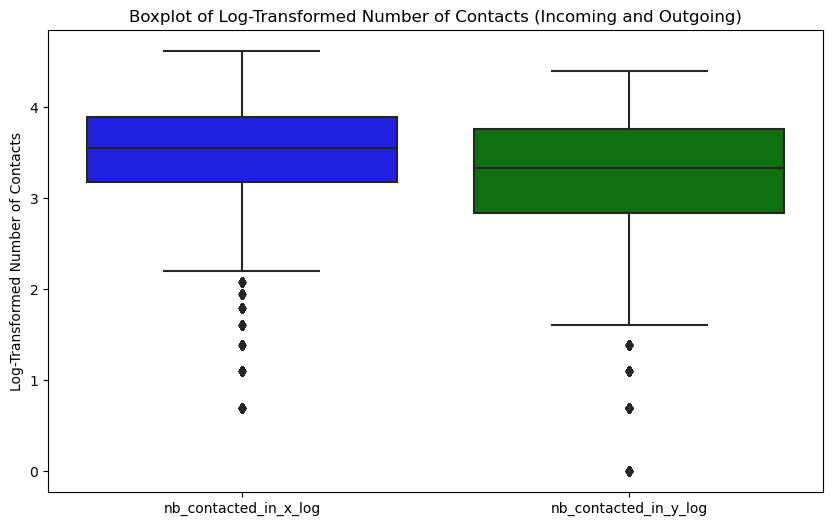

In [49]:
plt.figure(figsize=(10, 6)) 

# Replace NaN values with 0s in 'nb_contacted_in_x' and 'nb_contacted_in_y'
outer_df['nb_contacted_in_x'].fillna(0, inplace=True)
outer_df['nb_contacted_in_y'].fillna(0, inplace=True)

# Apply log transformation to 'nb_contacted_in_x' and 'nb_contacted_in_y'
outer_df['nb_contacted_in_x_log'] = np.log1p(outer_df['nb_contacted_in_x'])
outer_df['nb_contacted_in_y_log'] = np.log1p(outer_df['nb_contacted_in_y'])

# Create a boxplot for the log-transformed columns using Seaborn
sns.boxplot(data=outer_df[['nb_contacted_in_x_log', 'nb_contacted_in_y_log']], palette=['blue', 'green'])

# Add labels and a title
plt.ylabel('Log-Transformed Number of Contacts')
plt.title('Boxplot of Log-Transformed Number of Contacts (Incoming and Outgoing)')

# Show the plot
plt.show()

While the log transformation didn't completely remove outliers we can see that the distribution improved drastically and doesn't seem dominated solely by the outliers that dictated its shape prior to the transformation.

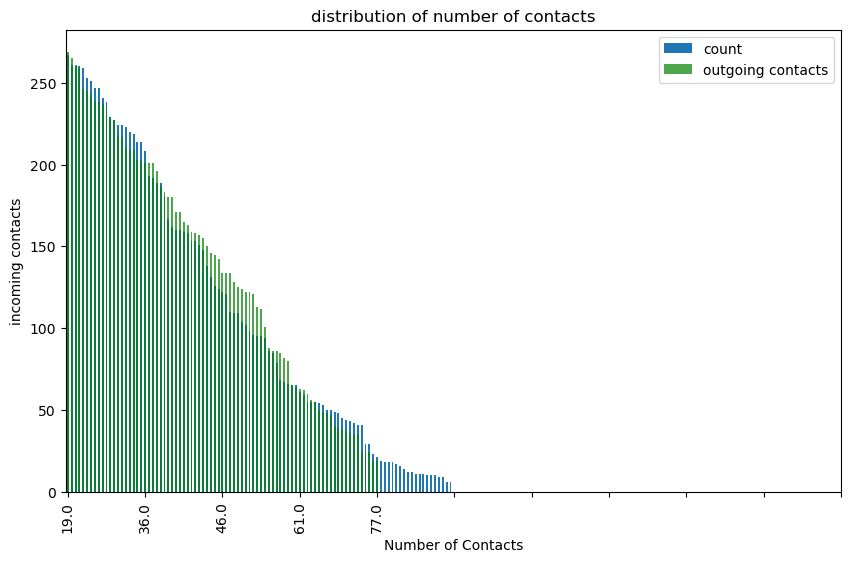

In [50]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Use the 'nb_contacted_in_x' column to create a count plot
outer_df['nb_contacted_in_x'].value_counts().plot(kind='bar')
outer_df['nb_contacted_in_y'].value_counts().plot(kind='bar', color='green', alpha=0.7, label='outgoing contacts')

# Add labels and a title
plt.xlabel('Number of Contacts')
plt.ylabel('incoming contacts')
plt.title('distribution of number of contacts')

# Add a legend to differentiate between the two columns
plt.legend()

# Customize the x-axis ticks with specific intervals (e.g., every 0.5)
x_ticks = [round(x, 1) for x in range(0, 201, 20)]
plt.xticks(x_ticks)
# Show the plot
plt.show()

More happy with this distribution than the initial one , moving on to the next features .


In [51]:
outer_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11040 entries, 0 to 3788626
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   revenu_upsell             11040 non-null  int64  
 1   decision_interested       11040 non-null  bool   
 2   decision_non interested   11040 non-null  bool   
 3   decision_unknown          11040 non-null  bool   
 4   nb_contacted_in_x         11040 non-null  float64
 5   nb_contacted_in_y         11040 non-null  float64
 6   recency                   5983 non-null   float64
 7   duration                  5983 non-null   float64
 8   nb_days_used_voice        11039 non-null  float64
 9   nb_days_used_sms          11039 non-null  float64
 10  nb_days_used_data         11039 non-null  float64
 11  mou_out                   10977 non-null  float64
 12  mou_out_onnet             10977 non-null  float64
 13  mou_out_offnet            11039 non-null  float64
 14  internati

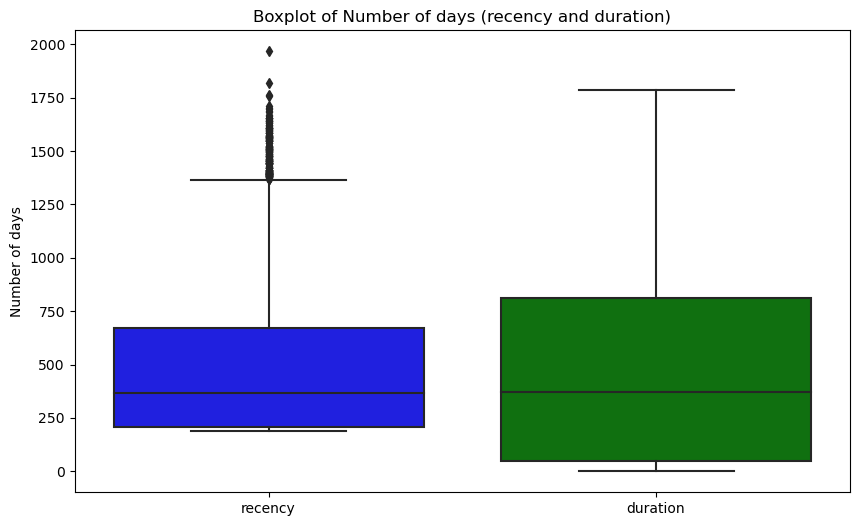

In [52]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Create a boxplot for 'nb_contacted_in_x' and 'nb_contacted_in_y' using Seaborn
sns.boxplot(data=outer_df[['recency', 'duration']], palette=['blue', 'green'])

# Add labels and a title
plt.ylabel('Number of days')
plt.title('Boxplot of Number of days (recency and duration)')

# Show the plot
plt.show()


duration seems to be fine, however recency suffers from some outlier values and a significant number of nan values. therefore we will be doing the same as we did for the incoming and outgoing contacts columns.

In [53]:
outer_df['recency'].fillna(0, inplace=True)
outer_df['duration'].fillna(0, inplace=True)


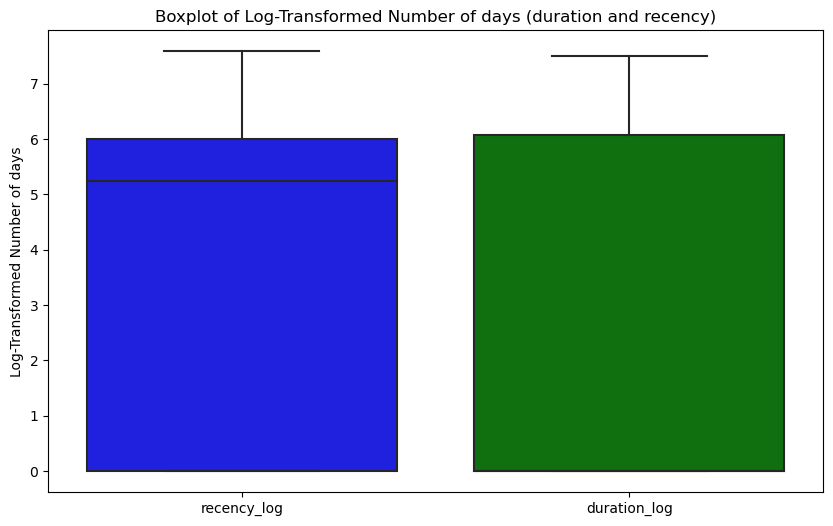

In [54]:
plt.figure(figsize=(10, 6)) 

# Replace NaN values with 0s in 'nb_contacted_in_x' and 'nb_contacted_in_y'
outer_df['recency'].fillna(0, inplace=True)
outer_df['duration'].fillna(0, inplace=True)

# Apply log transformation to 'nb_contacted_in_x' and 'nb_contacted_in_y'
outer_df['recency_log'] = np.log1p(outer_df['recency'])
outer_df['duration_log'] = np.log1p(outer_df['duration'])

# Create a boxplot for the log-transformed columns using Seaborn
sns.boxplot(data=outer_df[['recency_log', 'duration_log']], palette=['blue', 'green'])

# Add labels and a title
plt.ylabel('Log-Transformed Number of days')
plt.title('Boxplot of Log-Transformed Number of days (duration and recency)')

# Show the plot
plt.show()

In [55]:
outer_df.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 11040 entries, 0 to 3788626
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   revenu_upsell             11040 non-null  int64  
 1   decision_interested       11040 non-null  bool   
 2   decision_non interested   11040 non-null  bool   
 3   decision_unknown          11040 non-null  bool   
 4   nb_contacted_in_x         11040 non-null  float64
 5   nb_contacted_in_y         11040 non-null  float64
 6   recency                   11040 non-null  float64
 7   duration                  11040 non-null  float64
 8   nb_days_used_voice        11039 non-null  float64
 9   nb_days_used_sms          11039 non-null  float64
 10  nb_days_used_data         11039 non-null  float64
 11  mou_out                   10977 non-null  float64
 12  mou_out_onnet             10977 non-null  float64
 13  mou_out_offnet            11039 non-null  float64
 14  internati

In [56]:
#Since the remaining features contain a very small number of nan values we'll just fill them with 0s :
outer_df.fillna(0, inplace=True)

In [57]:
# List of columns to include in the new DataFrame
columns_to_include = [
    'revenu_upsell',
    'decision_interested',
    'decision_non interested',
    'decision_unknown',
    'nb_contacted_in_x_log',
    'nb_contacted_in_y_log',
    'recency_log',
    'duration_log',
    'nb_days_used_voice',
    'nb_days_used_sms',
    'nb_days_used_data',
    'mou_out',
    'mou_out_onnet',
    'mou_out_offnet',
    'nb_sms_out',
    'nb_sms_out_onnet',
    'nb_sms_out_offnet'
    
]

# Create the new DataFrame 'outer_training' by selecting the specified columns from the original DataFrame
outer_training = outer_df[columns_to_include]

# Choosing and training the models :

since the objective of this upsell notebook is to increase upsell we are interested in models that can display the importance of features in relation to the target value , we are looking to analyze this relationship in order to give our marketing team better instructions as to who to target. therefore the models we will be using are tree-based mostly . so we will use :
1) xgboost
3) random forest (catboost)
4) logistic regression

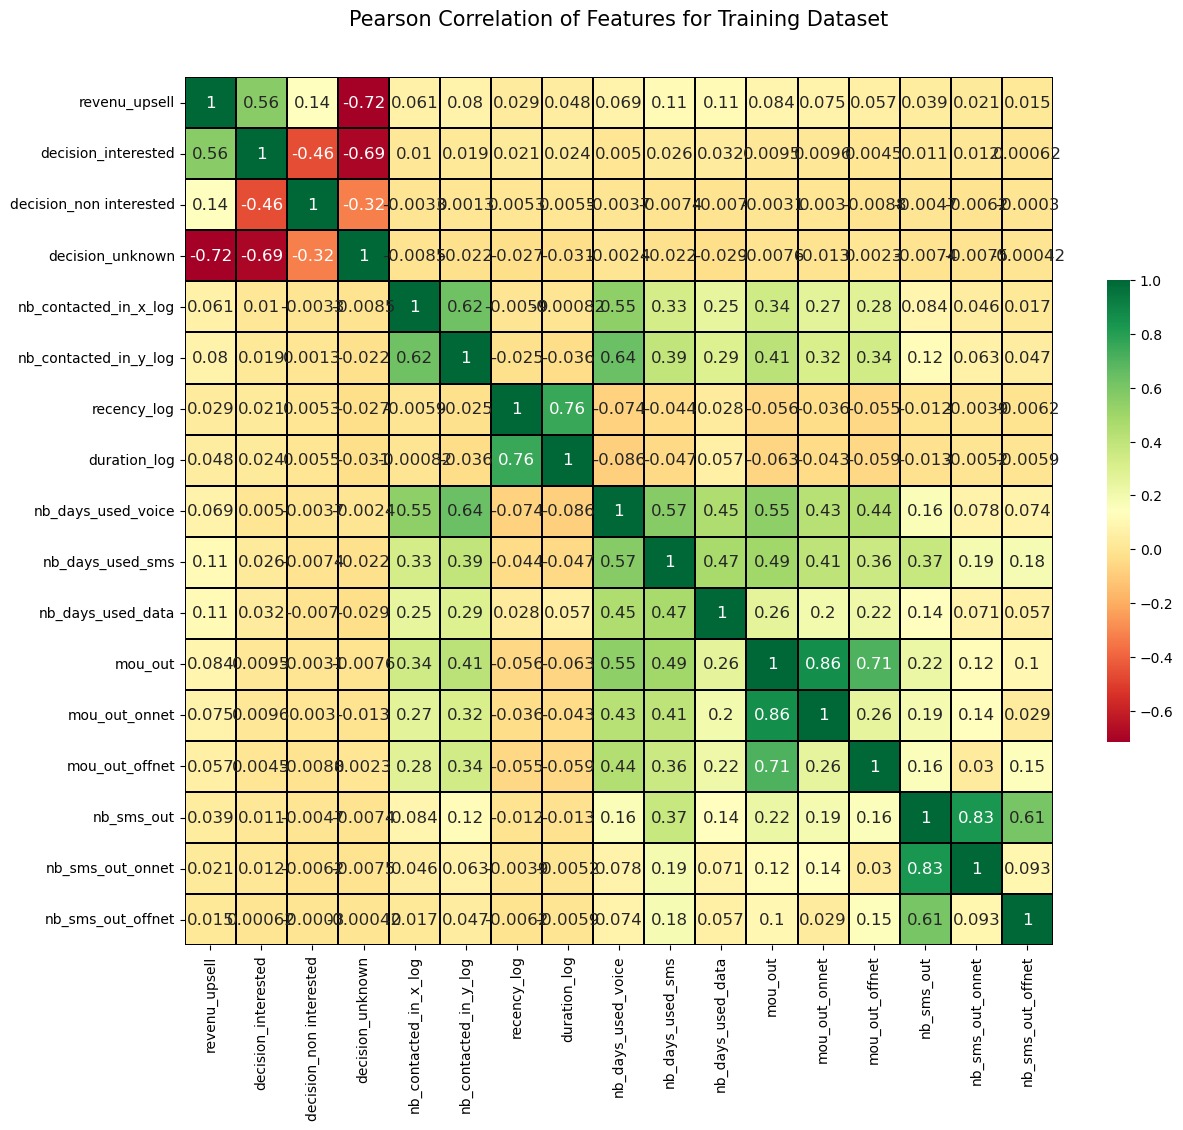

In [58]:
correlation_heatmap(outer_training)

the correlation heatmap shows that the decision_interested and decision_unknown are very uncorrelated which may indicate that most people with decision_unknown fall under the decision_non interested group. other than that our explanatory variables seem to be uncorrelated with each other which is a great sign since they each capture different aspects of the users' behaviors.

decisions : 
1) merge decision_non interested and decision_unknown into deicision_non interested
2) drop nb_sms_out_onnet since it's very correlated with nb_sms_out so they're explaining the same thing

In [59]:
# Merge 'decision_non interested' and 'decision_unknown'
outer_training['decision_non interested'] = outer_training['decision_non interested'] | outer_training['decision_unknown']

# Drop the 'decision_unknown' column
outer_training.drop(columns=['decision_unknown','nb_sms_out_onnet'], inplace=True)

In [60]:
#XGboost : 
# Split the data into features (X) and the target variable (y)
X = outer_training.drop(['revenu_upsell'], axis=1)
y = outer_training['revenu_upsell']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
# Train the model on the training data
model.fit(X_train, y_train,verbose = True,early_stopping_rounds=10,eval_metric ='aucpr',eval_set =[(X_test, y_test)])

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

# You can also access feature importances if you want to see which features are important
feature_importances = model.feature_importances_
print("Feature Importances:")
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")


[0]	validation_0-aucpr:0.55832
[1]	validation_0-aucpr:0.56068
[2]	validation_0-aucpr:0.56473
[3]	validation_0-aucpr:0.56222
[4]	validation_0-aucpr:0.56424
[5]	validation_0-aucpr:0.56720
[6]	validation_0-aucpr:0.55969
[7]	validation_0-aucpr:0.56241
[8]	validation_0-aucpr:0.56148
[9]	validation_0-aucpr:0.56224
[10]	validation_0-aucpr:0.56021
[11]	validation_0-aucpr:0.56121
[12]	validation_0-aucpr:0.56138
[13]	validation_0-aucpr:0.55924
[14]	validation_0-aucpr:0.55751
[15]	validation_0-aucpr:0.55702
Accuracy: 0.625
Confusion Matrix:
[[691  53   3]
 [304 611  63]
 [ 89 316  78]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.93      0.75       747
           1       0.62      0.62      0.62       978
           2       0.54      0.16      0.25       483

    accuracy                           0.62      2208
   macro avg       0.60      0.57      0.54      2208
weighted avg       0.61      0.62      0.59      2208

Feature Import

In [61]:
# Create and train the CatBoost classifier
model = CatBoostClassifier(iterations=1000,  # Adjust the number of iterations as needed
                           learning_rate=0.1,  # Adjust the learning rate as needed
                           depth=6,  # Adjust the depth of the trees as needed
                           loss_function='MultiClass',  # For multiclass classification
                           eval_metric='Accuracy',  # Evaluation metric
                           verbose=100)  # Print progress every 100 iterations

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
# Print feature importance
feature_importance = model.get_feature_importance(type='FeatureImportance')
print("Feature Importance:")
for feature_name, importance in zip(X.columns, feature_importance):
    print(f"{feature_name}: {importance}")


0:	learn: 0.6180933	total: 155ms	remaining: 2m 34s
100:	learn: 0.6459466	total: 590ms	remaining: 5.25s
200:	learn: 0.6743659	total: 1.03s	remaining: 4.1s
300:	learn: 0.7034647	total: 1.46s	remaining: 3.4s
400:	learn: 0.7290534	total: 1.91s	remaining: 2.85s
500:	learn: 0.7541893	total: 2.34s	remaining: 2.33s
600:	learn: 0.7790987	total: 2.77s	remaining: 1.84s
700:	learn: 0.8007246	total: 3.17s	remaining: 1.35s
800:	learn: 0.8234828	total: 3.56s	remaining: 886ms
900:	learn: 0.8420516	total: 3.98s	remaining: 437ms
999:	learn: 0.8594882	total: 4.4s	remaining: 0us
              precision    recall  f1-score   support

           0       0.64      0.86      0.73       747
           1       0.60      0.59      0.59       978
           2       0.41      0.20      0.27       483

    accuracy                           0.60      2208
   macro avg       0.55      0.55      0.53      2208
weighted avg       0.57      0.60      0.57      2208

Feature Importance:
decision_interested: 13.287115538

In [62]:
#Logistic Regression :

# Create and train the logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Print feature importance (coefficients for each feature)
feature_importance = model.coef_
print("Feature Importance (Coefficients):")
for feature_name, importance in zip(X.columns, feature_importance[0]):
    print(f"{feature_name}: {importance}")


              precision    recall  f1-score   support

           0       0.64      0.93      0.76       747
           1       0.62      0.65      0.64       978
           2       0.54      0.11      0.18       483

    accuracy                           0.63      2208
   macro avg       0.60      0.56      0.53      2208
weighted avg       0.61      0.63      0.58      2208

Feature Importance (Coefficients):
decision_interested: -1.190583171454151
decision_non interested: 1.2419068341043873
nb_contacted_in_x_log: -0.009910178538224445
nb_contacted_in_y_log: -0.06664347004227598
recency_log: 0.02077251467878306
duration_log: -0.03300170485703143
nb_days_used_voice: 0.0012290000380954038
nb_days_used_sms: -0.007230336397159484
nb_days_used_data: -0.006587769245070738
mou_out: 0.008323850057057679
mou_out_onnet: -0.008489209154675117
mou_out_offnet: -0.008268663399313196
nb_sms_out: 0.0001217765798308126
nb_sms_out_offnet: -0.000371309504976797


The cleaned outer merge data gives us an upper accuarcy of 62% which is honestly very bad to predict the classes. however it gives us an idea about the feature importances :
1) the first feature almost all of the models prioritized were the results of interest survey , this gives us direct insight into our customer's habits and whether or not they are above the selling threshhold thus increasing surveys and customer interaction will help the marketing team identify customers' in need of upsell strategies through their stated interest
2) the contact metrics come in second. indicating that the more a customer receives or initiates contact with others the more likely they are to be on the 'achat' category, so we can segment our customers based on how often they use the services and how often they are contacting/being contacted by others.
3) the recency and duration metrics seem to explain a significant portion of the variation as well . how many days since the last interactin with the service and how long the customer has been a client seem to be strong indicators of the customer's buying habits and we can use them to further create groups that we should focus on.

# INNNER MERGE DATA :

In [63]:
inner_df.isnull().sum()

revenu_upsell                0
decision_interested          0
decision_non interested      0
decision_unknown             0
nb_contacted_in_x            0
nb_contacted_in_y            0
recency                      0
duration                     0
nb_days_used_voice           0
nb_days_used_sms             0
nb_days_used_data            0
mou_out                     30
mou_out_onnet               30
mou_out_offnet               0
international_mou_out        0
volume_data                  0
nb_sms_out                   0
nb_sms_out_onnet             0
nb_sms_out_offnet            0
nb_sms_out_international     0
dtype: int64

unlike the outer merge, the inner merge has less data and doesn't create rows with missing data , as is shown in the dataframe we don't have a large number of missing values. however we may have outliers and data in need of scaling

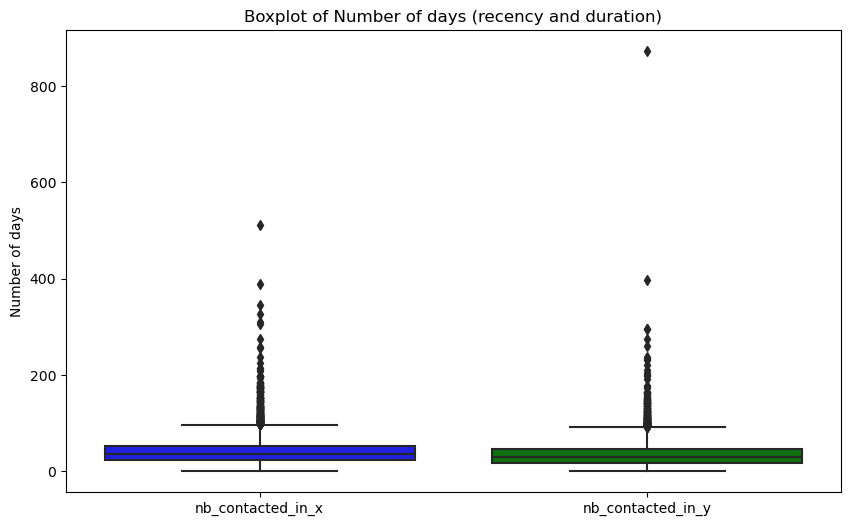

In [64]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Create a boxplot for 'nb_contacted_in_x' and 'nb_contacted_in_y' using Seaborn
sns.boxplot(data=inner_df[['nb_contacted_in_x', 'nb_contacted_in_y']], palette=['blue', 'green'])

# Add labels and a title
plt.ylabel('Number of days')
plt.title('Boxplot of Number of days (recency and duration)')

# Show the plot
plt.show()


just like the previous dataset , heavily unbalanced data and affected by a large number of outliers, we will do the same transforamtions we did earlier to fix this heavy skewedness

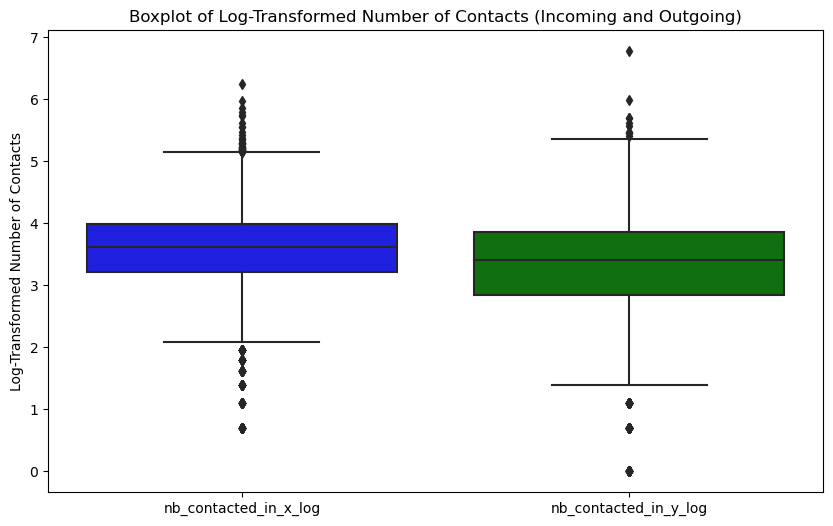

In [65]:
plt.figure(figsize=(10, 6)) 

# Apply log transformation to 'nb_contacted_in_x' and 'nb_contacted_in_y'
inner_df['nb_contacted_in_x_log'] = np.log1p(inner_df['nb_contacted_in_x'])
inner_df['nb_contacted_in_y_log'] = np.log1p(inner_df['nb_contacted_in_y'])

# Create a boxplot for the log-transformed columns using Seaborn
sns.boxplot(data=inner_df[['nb_contacted_in_x_log', 'nb_contacted_in_y_log']], palette=['blue', 'green'])

# Add labels and a title
plt.ylabel('Log-Transformed Number of Contacts')
plt.title('Boxplot of Log-Transformed Number of Contacts (Incoming and Outgoing)')

# Show the plot
plt.show()

In [66]:
# Apply log transformation to 'nb_contacted_in_x' and 'nb_contacted_in_y'
inner_df['recency_log'] = np.log1p(inner_df['recency'])
inner_df['duration_log'] = np.log1p(inner_df['duration'])

In [67]:
# List of columns to include in the new DataFrame
columns_to_include = [
    'revenu_upsell',
    'decision_interested',
    'decision_non interested',
    'decision_unknown',
    'nb_contacted_in_x_log',
    'nb_contacted_in_y_log',
    'recency_log',
    'duration_log',
    'nb_days_used_voice',
    'nb_days_used_sms',
    'nb_days_used_data',
    'mou_out',
    'mou_out_onnet',
    'mou_out_offnet',
    'nb_sms_out',
    'nb_sms_out_onnet',
    'nb_sms_out_offnet'
    
]

# Create the new DataFrame 'outer_training' by selecting the specified columns from the original DataFrame
inner_training = inner_df[columns_to_include]

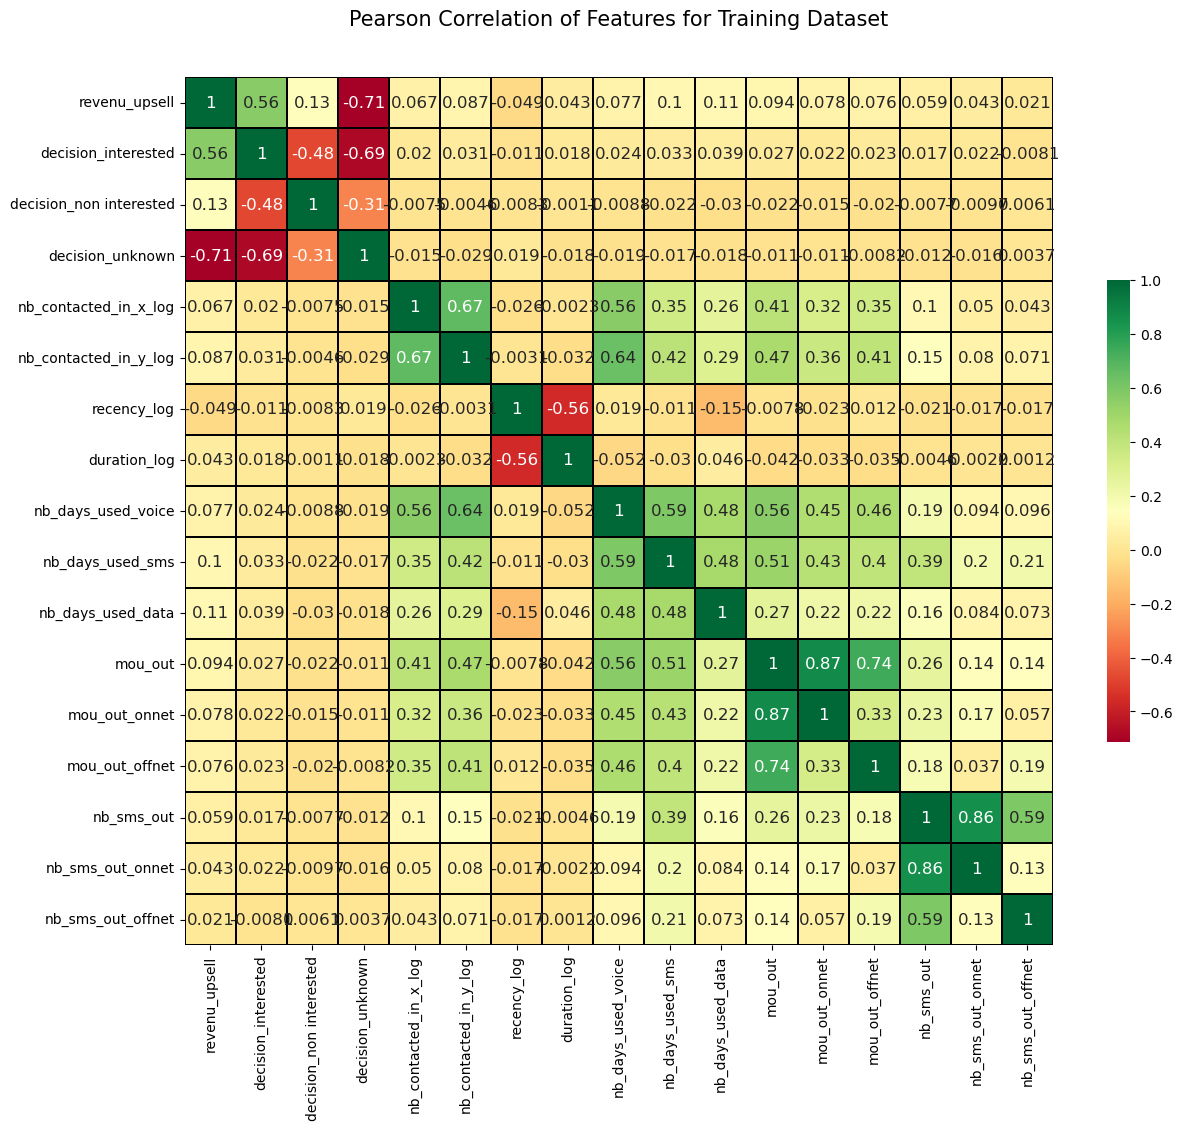

In [68]:
correlation_heatmap(inner_training)

 Exact same observations as earlier , which isn't weird since it's the same data

In [69]:
#dropping highly correlated columns :
inner_training.drop(columns=['mou_out','nb_sms_out',], inplace=True)

In [70]:
#XGboost : 
# Split the data into features (X) and the target variable (y)
X = inner_training.drop(['revenu_upsell'], axis=1)
y = inner_training['revenu_upsell']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
# Train the model on the training data
model.fit(X_train, y_train,verbose = True,early_stopping_rounds=10,eval_metric ='aucpr',eval_set =[(X_test, y_test)])

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

# You can also access feature importances if you want to see which features are important
feature_importances = model.feature_importances_
print("Feature Importances:")
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")


[0]	validation_0-aucpr:0.61724
[1]	validation_0-aucpr:0.61933
[2]	validation_0-aucpr:0.62712
[3]	validation_0-aucpr:0.63154
[4]	validation_0-aucpr:0.63390
[5]	validation_0-aucpr:0.63349
[6]	validation_0-aucpr:0.63195
[7]	validation_0-aucpr:0.63005
[8]	validation_0-aucpr:0.62982
[9]	validation_0-aucpr:0.62730
[10]	validation_0-aucpr:0.62553
[11]	validation_0-aucpr:0.62252
[12]	validation_0-aucpr:0.62208
[13]	validation_0-aucpr:0.62277
[14]	validation_0-aucpr:0.62186
Accuracy: 0.6891996891996892
Confusion Matrix:
[[367  63   3]
 [ 30 451  56]
 [ 17 231  69]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       433
           1       0.61      0.84      0.70       537
           2       0.54      0.22      0.31       317

    accuracy                           0.69      1287
   macro avg       0.68      0.64      0.63      1287
weighted avg       0.68      0.69      0.66      1287

Feature Importances:
decision_int

much better accuarcy , almost 70%, hooray!!

In [71]:
# Create and train the CatBoost classifier
model = CatBoostClassifier(iterations=1000,  # Adjust the number of iterations as needed
                           learning_rate=0.1,  # Adjust the learning rate as needed
                           depth=6,  # Adjust the depth of the trees as needed
                           loss_function='MultiClass',  # For multiclass classification
                           eval_metric='Accuracy',  # Evaluation metric
                           verbose=100)  # Print progress every 100 iterations

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
# Print feature importance
feature_importance = model.get_feature_importance(type='FeatureImportance')
print("Feature Importance:")
for feature_name, importance in zip(X.columns, feature_importance):
    print(f"{feature_name}: {importance}")


0:	learn: 0.6787796	total: 5.27ms	remaining: 5.26s
100:	learn: 0.7347454	total: 347ms	remaining: 3.08s
200:	learn: 0.7800233	total: 760ms	remaining: 3.02s
300:	learn: 0.8130587	total: 1.12s	remaining: 2.61s
400:	learn: 0.8499806	total: 1.45s	remaining: 2.16s
500:	learn: 0.8754372	total: 1.76s	remaining: 1.75s
600:	learn: 0.9010882	total: 2.07s	remaining: 1.37s
700:	learn: 0.9226584	total: 2.36s	remaining: 1.01s
800:	learn: 0.9383988	total: 2.67s	remaining: 662ms
900:	learn: 0.9529732	total: 2.97s	remaining: 326ms
999:	learn: 0.9638554	total: 3.27s	remaining: 0us
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       433
           1       0.58      0.72      0.64       537
           2       0.39      0.25      0.31       317

    accuracy                           0.65      1287
   macro avg       0.62      0.61      0.60      1287
weighted avg       0.63      0.65      0.63      1287

Feature Importance:
decision_interested: 6.5816898

In [72]:
#Logistic Regression :
X_train.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
y_test.fillna(0, inplace= True)
# Create and train the logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Print feature importance (coefficients for each feature)
feature_importance = model.coef_
print("Feature Importance (Coefficients):")
for feature_name, importance in zip(X.columns, feature_importance[0]):
    print(f"{feature_name}: {importance}")


              precision    recall  f1-score   support

           0       0.89      0.85      0.87       433
           1       0.60      0.87      0.71       537
           2       0.53      0.15      0.24       317

    accuracy                           0.69      1287
   macro avg       0.67      0.62      0.61      1287
weighted avg       0.68      0.69      0.65      1287

Feature Importance (Coefficients):
decision_interested: -1.6730151369955566
decision_non interested: -0.60793555363611
decision_unknown: 2.332580649814271
nb_contacted_in_x_log: -0.03879438637892136
nb_contacted_in_y_log: -0.11263466525888141
recency_log: 0.12395155063971977
duration_log: -0.025303497463766655
nb_days_used_voice: 0.011655895295680313
nb_days_used_sms: -0.009107839845881023
nb_days_used_data: -0.016720179657742838
mou_out_onnet: -0.0002835302866418373
mou_out_offnet: -1.7823944387028924e-05
nb_sms_out_onnet: -0.0005532283122415907
nb_sms_out_offnet: -0.0007902957555962559


 # Conclusions  : 
using the inner merge data yielded a better global accuarcy overall jumping from low 60% to 67-69%..although the jump is decent and indicates that there is more to derive from our data I believe the main thing to notice here that the feature importance remains unchanged. the order by which the features contribute to deciding the target variable is the same and gives us the same order of importance as the last data.

1) The interest survey results were the first feature that almost all of the models prioritized. This gives us direct insight into our customers' habits and determines whether or not they are above the selling threshold; therefore, increasing surveys and customer interaction will help the marketing team identify customers who need upsell strategies by their stated interests.
2) Contact metrics came in second. We may categorize our clients depending on how frequently they use the services and how frequently they contact/are contacted by others. This indicates that the more a customer receives or initiates interaction with others, the more likely they are to be on the "achat" group.
3) A sizable percentage of the variation appears to be explained by the recency and duration measurements as well. How long a customer has been a client and how many days have passed since their most recent interaction with the business appear to be good predictors of the consumer's purchasing patterns, and we may utilize these to further form groups that we should focus on.

# Global conclusion :
The RFM analysis gives us a better segmentation of our customer base and gives us general directions we can take to satisfy their needs, however the models give us more insight into what features exactly matter in guaging the interest of our customers and what actions we can directly take to satisfy their needs. Both methods of analysis are useful and in tendem they can lead us to segment the customerbase using RFM and then develop strategies of engagement based on the features our models derived .

Feature importance :

1) customer's opinions on surveys
2) volume of contacts commited or received by the customer
3) how long the customer has been using the service
4) how recent the customer's last usage of the service was